# Обучение шумного автокодировщика

- Добавить ко входным данным нормальный шум
- Сделать отражение части изображения
- Отрисовать карты активаций нейронов первого слоя


Импортируем все требуемые зависимости

In [229]:
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

Определяем среду

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Подготовка данных

Подготовим датасет, используем Flowers102 (8189 изображений размером 256x256 пикселей, разделенных на 102 класса)

Объявим функцию для добавления белого шума на изображения

In [134]:
def add_noise(image, noise_prob=0.5, noise_level=0.1):
    if random.random() < noise_prob:
        noise = torch.randn_like(image) * noise_level
        image = image + noise
        image = torch.clamp(image, 0, 1)
    return image

Объявим функцию для отражения части изображений, случайным образом отзеркаливаем патчи по-умолчанию размером 16x16 пикселей

In [135]:
def random_mirror(image, mirror_prob=0.5, patch_size=16):
    if random.random() < mirror_prob:
        height, width = image.shape[-2], image.shape[-1]
        top = random.randint(0, height - patch_size)
        left = random.randint(0, width - patch_size)
        
        patch = image[..., top:top+patch_size, left:left+patch_size]
        mirrored_patch = torch.flip(patch, [-1])
        
        image[..., top:top+patch_size, left:left+patch_size] = mirrored_patch
        
    return image

Добавим их в пайплайн трансформаций, используем отдин и тот же пайплайн и для тестовых и для тренировочных данных

In [136]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    add_noise,
    random_mirror
])

In [137]:
def dataset(batch_size=50, valid=0, shuffle=True, transform=transform, path='./dataset'):
    
    train_data = datasets.Flowers102(root=path, split='train', transform=transform, download=True)
    test_data =  datasets.Flowers102(root=path, split='test', transform=transform, download=True)

    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, shuffle=True)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, shuffle=True)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader, test_loader

In [138]:
train_loader, test_loader = dataset(batch_size=102, valid=0, transform=transform)

Взглянем на примеры изображений

In [139]:
data, _ = next(iter(train_loader))

In [271]:
def plot_images(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=150)
    for j in range(len(images)):
        ax = fig.add_subplot(shape[0], shape[1], j + 1)
        ax.matshow(images[j].permute(1, 2, 0).cpu().detach().numpy(), cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

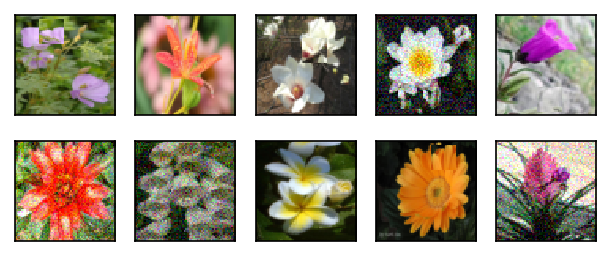

In [141]:
plot_images(data.data[0:10], (2, 5))

## Архитектура автоэнкодера

Объявляем класс классического вариационного автоэнкодера

In [142]:
class VAE(nn.Module):

    def __init__(self, in_channels, latent_dim, hidden_dims = [32, 128, 256, 1024, 2048], lr=1e-4, l2=0., **kwargs):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

        self._loss = None
        self.kld_factor = 0.
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 2048, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z), mu, log_var

    def loss(self, x, mu, log_var, target, **kwargs):
        recons_loss = F.mse_loss(x, target, **kwargs)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        self._loss = recons_loss + self.kld_factor * kld_loss
        return self._loss


In [143]:
models = {'vae': VAE(3, 256).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

## Обучение модели

Проведем обучение, используя лекционные материалы

In [144]:
def train(epoch, models, log=None):
    # Определяем размер обучающего набора данных.
    train_size = len(train_loader.sampler)
    # Проходим по каждому батчу в обучающем наборе данных.
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # Добавляем случайный шум к входным данным.
        noized = add_noise(data)
        # Проходим по каждой модели в словаре моделей.
        for model in models.values():
            # Обнуляем градиенты оптимизатора модели.
            model.optim.zero_grad()
            # Применяем модель к зашумленным данным.
            output, mu, log_var = model(noized)
            # Вычисляем значение функции потерь между восстановленными данными и оригинальными данными.
            loss = model.loss(output, mu, log_var, data)
            # Обратное распространение градиентов.
            loss.backward()
            # Обновление весов модели с помощью оптимизатора.
            model.optim.step()

        # Печать промежуточных результатов каждые 150 батчей.
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            # Форматирование строки для вывода значений потерь для каждой модели.
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            # Печать строки с информацией о текущей эпохе и значениями потерь для каждой модели.
            print(line + losses)

    # Печать результатов для последнего батча в эпохе.
    else:
        # Увеличиваем номер текущего батча на единицу.
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        # Форматирование строки для вывода значений потерь для каждой модели.
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        # Если передан лог, то добавляем значения потерь для каждой модели.
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        # Печать строки с информацией о текущей эпохе и значениями потерь для каждой модели.
        print(line + losses)

In [145]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
# Определение анонимной функции (lambda-выражения), которая принимает значение потерь l и форматирует его в строку 'loss: {:.4f}'.
# Здесь {:.4f} - это спецификатор формата, который указывает на формат вывода числа с плавающей точкой с 4 знаками после запятой.

line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
# Определение анонимной функции (lambda-выражения), которая принимает индекс i и значение потерь l, а затем формирует строку вида 'i: loss: {:.4f}'.

def test(models, loader, log=None):
    '''
    Функция test выполняет тестирование моделей на тестовом наборе данных.
    Внутри функции сначала вычисляются потери для каждой модели,
    затем нормализуются и выводятся в отчет.
    '''
    # Получаем размер тестового набора данных.
    test_size = len(loader.sampler)

    # Инициализируем словарь для хранения общих потерь для каждой модели.
    test_loss = {k: 0. for k in models}
    # Выполняем предсказания на тестовом наборе данных без вычисления градиентов.
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            # Добавляем случайный шум к входным данным.
            noized = add_noise(data)
            # Получаем предсказания для каждой модели из словаря.
            output = {k: m(noized) for k, m in models.items()}
            # Вычисляем потери для каждой модели и суммируем их.
            for k, m in models.items():
                test_loss[k] += m.loss(*output[k], data, reduction='sum').item()

    # Делим общие потери на количество пикселей в тестовом наборе данных для нормализации.
    for k in models:
        test_loss[k] /= (test_size * 64 * 64)
        # Если передан лог, то добавляем значения потерь для каждой модели.
        if log is not None:
            log[k].append(test_loss[k])

    # Формируем строки с результатами тестирования для каждой модели.
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    # Выводим отчет о тестировании.
    print(report)

In [160]:
for epoch in range(1, 30):

    for model in models.values():
        model.train()

    train(epoch, models, train_log)

    for model in models.values():
        model.eval()

    test(models, test_loader, test_log)
    
torch.save(model.state_dict(), 'model.pth')

Train Epoch: 1 [00000/1020] vae: 0.015843
Train Epoch: 1 [01020/1020] vae: 0.017236
Test set:
vae: loss: 0.0759

Train Epoch: 2 [00000/1020] vae: 0.015902
Train Epoch: 2 [01020/1020] vae: 0.017671
Test set:
vae: loss: 0.0749

Train Epoch: 3 [00000/1020] vae: 0.015616
Train Epoch: 3 [01020/1020] vae: 0.017009
Test set:
vae: loss: 0.0757

Train Epoch: 4 [00000/1020] vae: 0.016172
Train Epoch: 4 [01020/1020] vae: 0.016954
Test set:
vae: loss: 0.0749

Train Epoch: 5 [00000/1020] vae: 0.015129
Train Epoch: 5 [01020/1020] vae: 0.015572
Test set:
vae: loss: 0.0744

Train Epoch: 6 [00000/1020] vae: 0.015709
Train Epoch: 6 [01020/1020] vae: 0.015839
Test set:
vae: loss: 0.0737

Train Epoch: 7 [00000/1020] vae: 0.015403
Train Epoch: 7 [01020/1020] vae: 0.016558
Test set:
vae: loss: 0.0762

Train Epoch: 8 [00000/1020] vae: 0.015148
Train Epoch: 8 [01020/1020] vae: 0.015783
Test set:
vae: loss: 0.0744

Train Epoch: 9 [00000/1020] vae: 0.014856
Train Epoch: 9 [01020/1020] vae: 0.015705
Test set:
va

## Визуализация восстановления изображений

Посмотрим на результаты работы для разных уровней шума

Исходные изображения


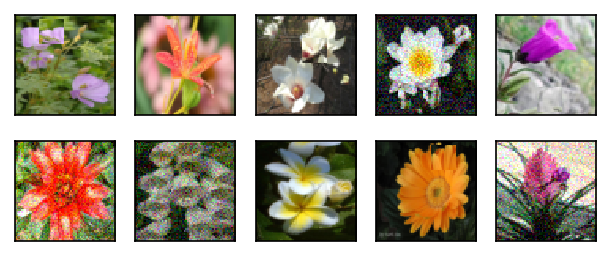

Восстановленные изображения


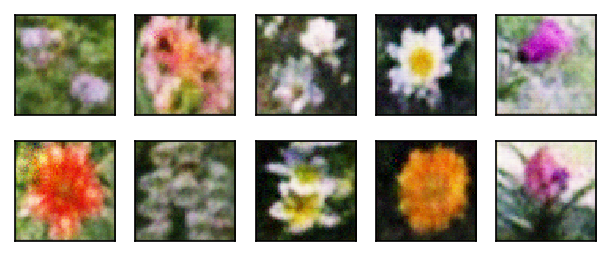

In [295]:
output = torch.clamp(models['vae'](data.to(device))[0], min=0, max=1)

print('Исходные изображения')
plot_images(data.data[:10], (2, 5))
print('Восстановленные изображения')
plot_images(output[:10], (2, 5))

Исходные изображения


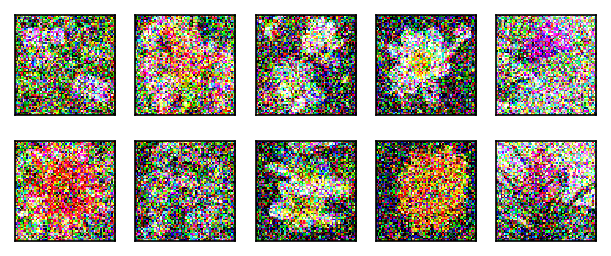

Восстановленные изображения


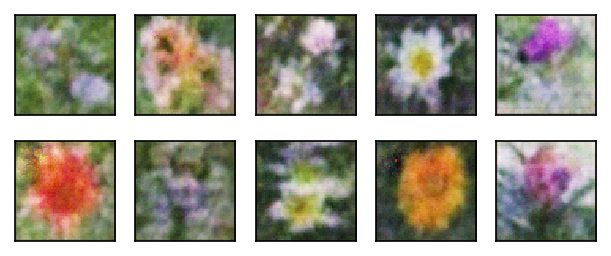

In [296]:
noised = add_noise(data.data[:10], noise_level=0.5, noise_prob=1)
output = torch.clamp(models['vae'](noised.to(device))[0], min=0, max=1)

print('Исходные изображения')
plot_images(noised[:10], (2, 5))
print('Восстановленные изображения')
plot_images(output[:10], (2, 5))

Исходные изображения


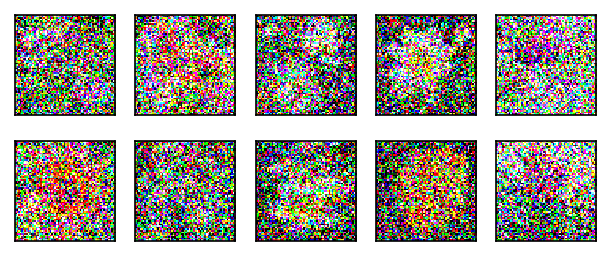

Восстановленные изображения


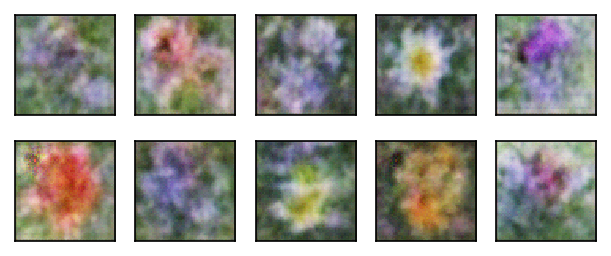

In [297]:
noised = add_noise(data.data[:10], noise_level=0.8, noise_prob=1)
output = torch.clamp(models['vae'](noised.to(device))[0], min=0, max=1)

print('Исходные изображения')
plot_images(noised[:10], (2, 5))
print('Восстановленные изображения')
plot_images(output[:10], (2, 5))

## Карты активации первого слоя энкодера

Визуализируем карты активаций

In [299]:
model = VAE(3, 256)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [304]:
hidden_outputs = []
def hook_fn(module, input, output):
    hidden_outputs.append(output)

for layer in model.encoder.children():
    layer[0].register_forward_hook(hook_fn)

model(data[5:6]);

Исходное изображение


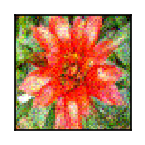

Карты активаций первого слоя


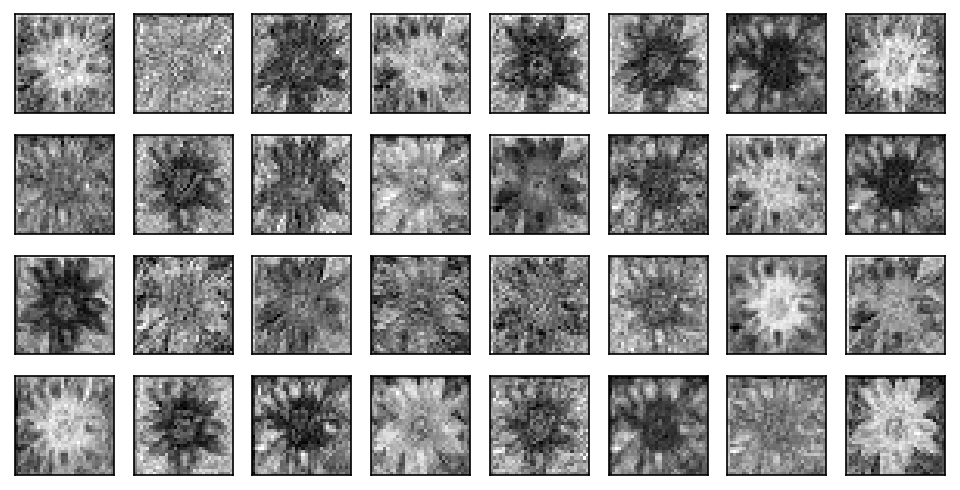

In [305]:
maps = []
for i in range(len(hidden_outputs[0][0])):
    maps.append(hidden_outputs[0][0][i:i+1] * 255)
    
print('Исходное изображение')
plot_images(data[5:6], (1,1))
print('Карты активаций первого слоя')
plot_images(maps, (4,8))